In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# Описание данных и цель анализа

**Описание данных:**  
Датасет содержит информацию, необходимую для выполнения кластерного анализа клиентов:  
1. **Демографические характеристики**: показатели, такие как возраст, пол и регион проживания, позволяют выявить различия между клиентскими группами.  
2. **Данные о расходах**: суммы затрат клиентов на различные категории товаров помогают проанализировать их покупательское поведение и ключевые направления расходов.  
3. **Участие в маркетинговых акциях**: информация о вовлеченности клиентов в программы лояльности, использование скидок и другие активности.  

**Цель анализа:**  
Выполнить кластеризацию клиентов для сегментации на основе схожих характеристик и поведения. Результаты сегментации будут использованы для:  
- Разработки таргетированных маркетинговых стратегий.  
- Предложения персонализированных услуг.  
- Повышения эффективности взаимодействия с клиентами.  


In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

# Предобработка данных

In [3]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [4]:
df.shape

(2240, 29)

In [5]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')

In [6]:
df['adults'] = df.Marital_Status.replace({"Married": 2,
                                          "Together": 2,
                                          "Single": 1,
                                          "Divorced": 1,
                                          "Widow": 1,
                                          "Alone": 1,
                                          "Absurd": 1,
                                          "YOLO": 1
})

df['childs'] = df.Kidhome + df.Teenhome
df['is_parent'] = df.childs.apply(lambda x: True if x >= 1 else False)
df['family_size'] = df['adults'] + df['childs']
df['tenure'] = (df.Dt_Customer.max() - df.Dt_Customer).dt.days

df['age'] = 2025 - df['Year_Birth']

df['total_spent'] = df[["MntWines", "MntFruits", "MntMeatProducts", 
                        "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['accepted_campaigns'] = df[campaigns].sum(axis=1)

df = df.rename(columns={"MntWines": "Wine",
                        "MntFruits": "Fruits",
                        "MntMeatProducts": "Meat",
                        "MntFishProducts": "Fish",
                        "MntSweetProducts": "Sweet",
                        "MntGoldProds": "Gold",
                        "NumDealsPurchases": "Deals",
                        "NumWebPurchases": "Web",
                        "NumCatalogPurchases": "Catalog",
                        "NumStorePurchases": "Store"
})

to_drop = ["Kidhome", "Teenhome", "Dt_Customer", "Year_Birth",
           "Z_CostContact", "Z_Revenue", "Marital_Status", "ID",
           'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
           'AcceptedCmp4', 'AcceptedCmp5']

df.drop(columns=to_drop, inplace=True)

df.head()

Education   Income  Recency  Wine  Fruits  Meat  Fish  Sweet  Gold  Deals  \
0  Graduation  58138.0       58   635      88   546   172     88    88      3   
1  Graduation  46344.0       38    11       1     6     2      1     6      2   
2  Graduation  71613.0       26   426      49   127   111     21    42      1   
3  Graduation  26646.0       26    11       4    20    10      3     5      2   
4         PhD  58293.0       94   173      43   118    46     27    15      5   

   ...  Complain  Response  adults  childs  is_parent  family_size  tenure  \
0  ...         0         1       1       0      False            1     663   
1  ...         0         0       1       2       True            3     113   
2  ...         0         0       2       0      False            2     312   
3  ...         0         0       2       1       True            3     139   
4  ...         0         0       2       1       True            3     161   

   age  total_spent  accepted_campaigns  
0   68         1617                   0  
1   71           27                   0  
2   60          776                   0  
3   41           53                   0  
4   44          422                   0  

[5 rows x 24 columns]

Внесенные изменения:

1. **Создание признака `adults`**:  
   Категория семейного статуса (`Marital_Status`) преобразована в числовой формат, где:  
   - "Married" и "Together" — 2 взрослых.  
   - Остальные статусы ("Single", "Divorced", "Widow", "Alone", "Absurd", "YOLO") — 1 взрослый.  

   Это позволяет учитывать количество взрослых членов семьи при дальнейших расчетах.  

2. **Создание признаков, связанных с детьми и семьей**:  
   - `childs`: сумма значений колонок `Kidhome` и `Teenhome`, отражающая общее количество детей в семье.  
   - `is_parent`: булевый признак, указывающий на наличие детей в семье (`True`, если есть хотя бы один ребенок).  
   - `family_size`: общее количество членов семьи, включая взрослых и детей (`adults + childs`).  

3. **Добавление признака `tenure`**:  
   Рассчитывается количество дней с момента регистрации клиента (`Dt_Customer`) до самой поздней даты в датасете. Этот признак показывает "стаж" клиента.  

4. **Расчет возраста клиента (`age`)**:  
   Возраст рассчитывается как разница между текущим годом (2025) и годом рождения клиента (`Year_Birth`).  

5. **Сумма расходов (`total_spent`)**:  
   Рассчитывается общая сумма затрат клиента на различные категории товаров (`MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`, `MntGoldProds`).  

6. **Количество принятых предложений в рамках промо кампаний**:  
   Рассчитывается общее количество промо кампаний в которых клиент принял участие

6. **Переименование колонок для удобства анализа**:  
   - Категории товаров:  
     - `MntWines` → `Wine`,  
     - `MntFruits` → `Fruits`, и так далее.  
   - Категории покупок:  
     - `NumDealsPurchases` → `Deals`,  
     - `NumWebPurchases` → `Web`, и так далее.  

7. **Удаление ненужных колонок**:  
   Из датасета удаляются следующие признаки, которые либо не несут полезной информации, либо были преобразованы:  
   - `Kidhome` и `Teenhome` (заменены на `childs`),  
   - `Dt_Customer` (заменен на `tenure`),  
   - `Year_Birth` (заменен на `age`),  
   - `Z_CostContact` и `Z_Revenue` (постоянные значения без полезной вариативности),  
   - `Marital_Status` (заменен на `adults`),  
   - `ID` (не используется в анализе).
   - `AcceptedCmp` (заменены на `accepted_campagins`)

## Визуализация данных: анализ основных числовых переменных

**Цель:**  
Построить график pairplot для основных числовых переменных, чтобы оценить их распределение, взаимосвязи и наличие выбросов.  

**Основные переменные для анализа:**  
- Возраст клиента (`age`),  
- Суммарные расходы (`total_spent`),   
- Стаж клиента (`tenure`), 
- Доход (`income`).  


<Figure size 800x600 with 0 Axes>

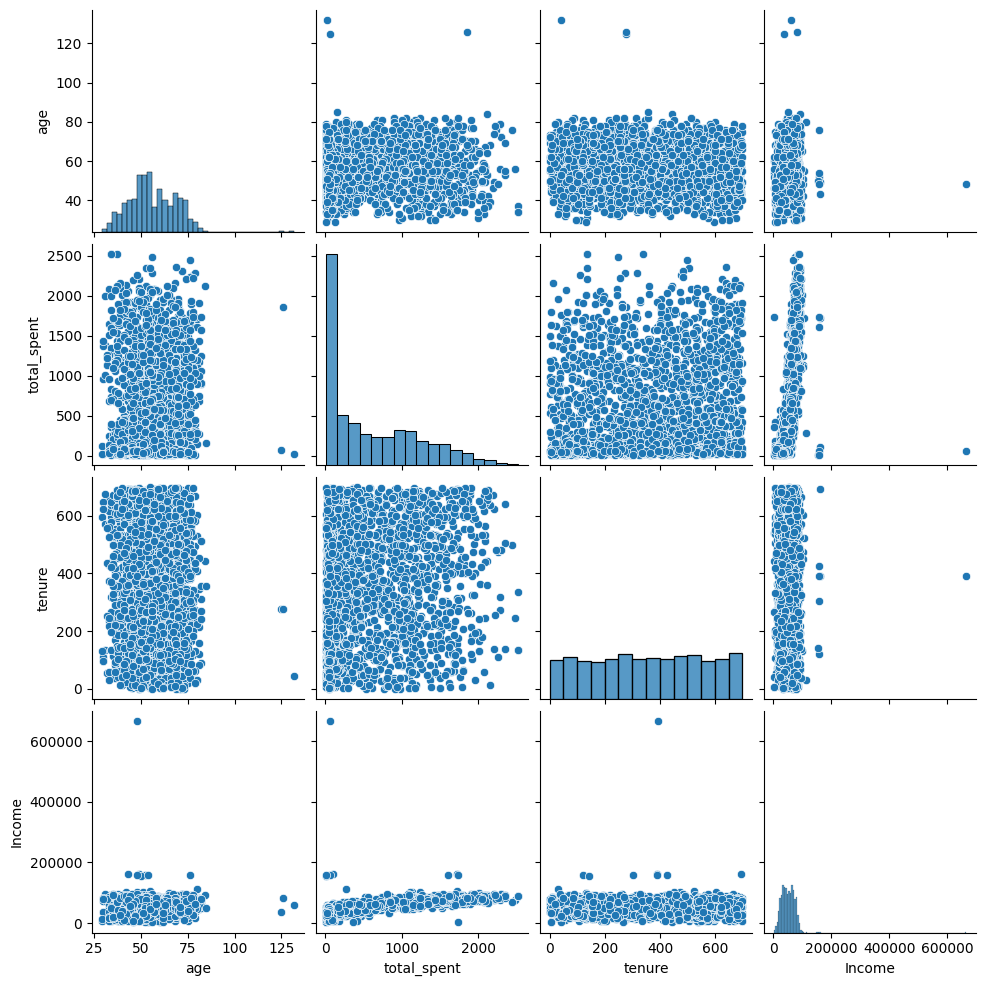

In [7]:
plt.figure(figsize=(8,6))

to_plot = df[['age', 'total_spent', 'tenure', 'Income']]

sns.pairplot(to_plot)

In [8]:
df = df[(df.age < 100) & (df.Income < 600000)]

### Устранение выбросов в переменных `income` и `age`

**Наблюдение:**  
На графике pairplot заметны явные выбросы в переменных:  
- `income` (уровень дохода),  
- `age` (возраст клиента).  

**Решение:**  
Чтобы избежать искажения результатов анализа, выбросы в этих переменных будут исключены из рассмотрения. 


## Анализ корреляции переменных

**Цель:**   
- Оценить степень взаимосвязи между переменными.  
- Определить, какие переменные могут быть исключены из дальнейшего анализа из-за низкой информативности.  

Этот шаг поможет отобрать наиболее значимые признаки для кластеризации и нерелевантные данные.  


<Axes: >

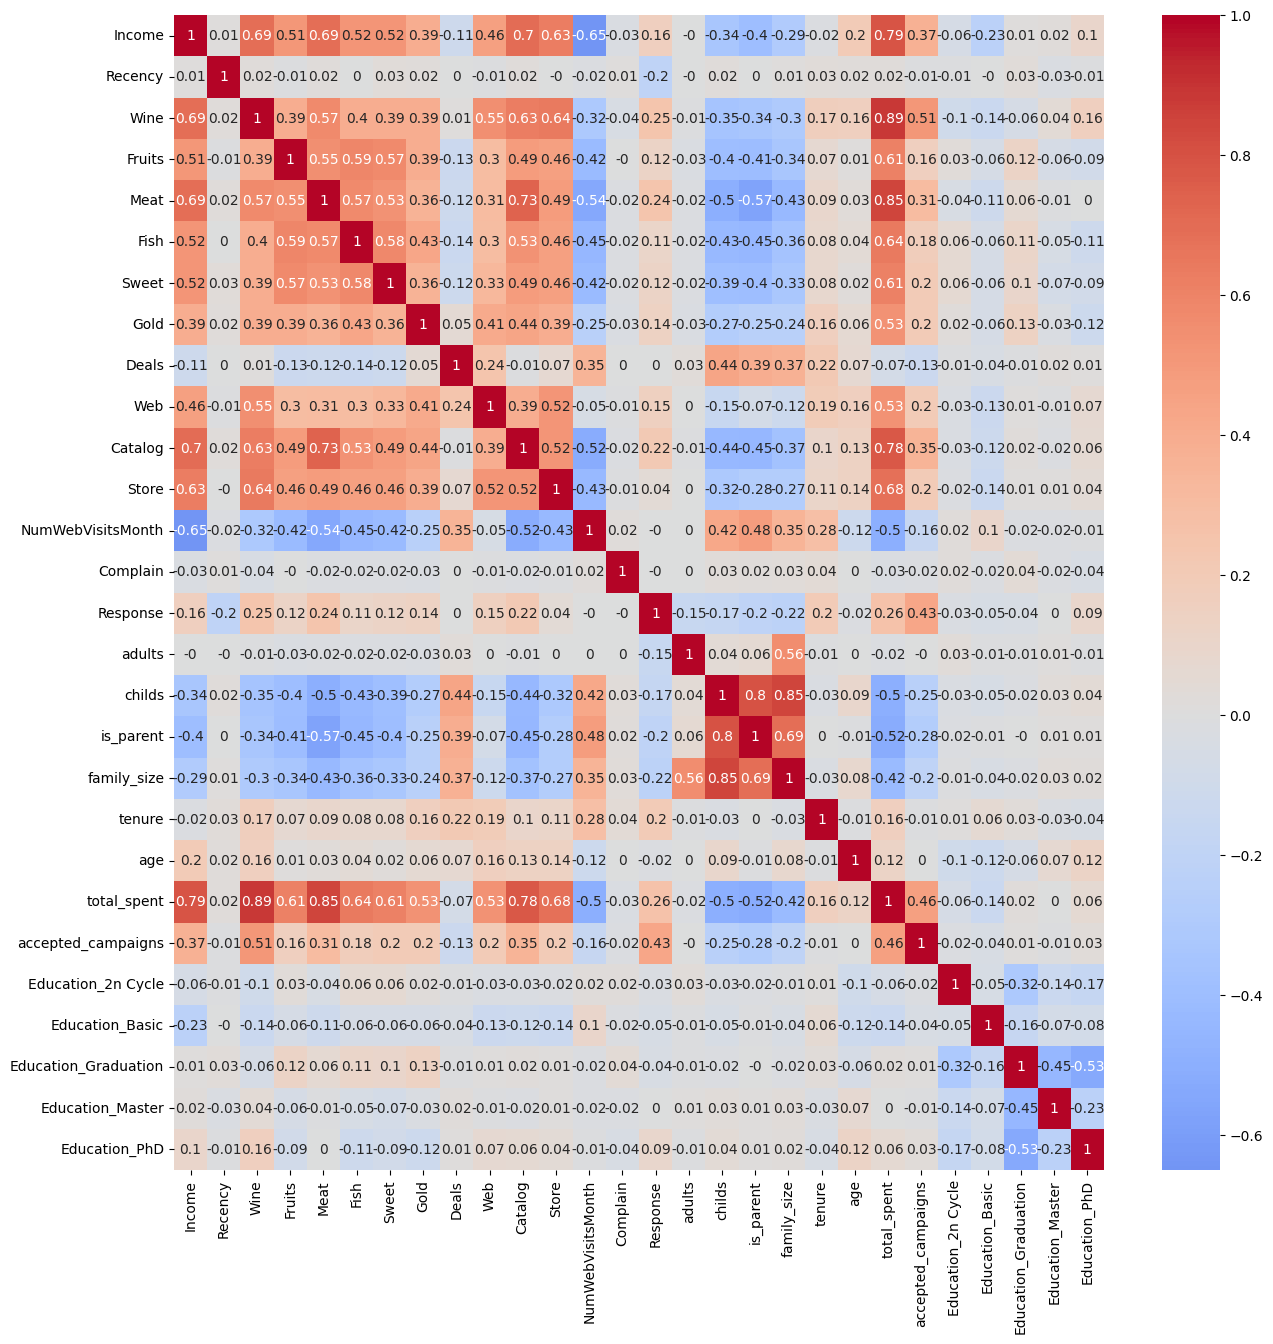

In [9]:
df_dummy = pd.get_dummies(df)

plt.figure(figsize=(15,15))

sns.heatmap(df_dummy.corr().round(2), cmap='coolwarm', annot=True, center=0)

Heatmap показал, что следующие переменные имеют слабую корреляцию с остальными:  
- `Complain` (наличие жалоб),  
- `Recency` (количество дней с момента последней покупки),  
- `Response` (участие в последней акции),  
- `Education` (уровень образования).
- `tenure` (стаж клиента)

Эти переменные будут исключены из дальнейшего анализа, так как их слабая корреляция указывает на низкую значимость для кластеризации. 


<Axes: >

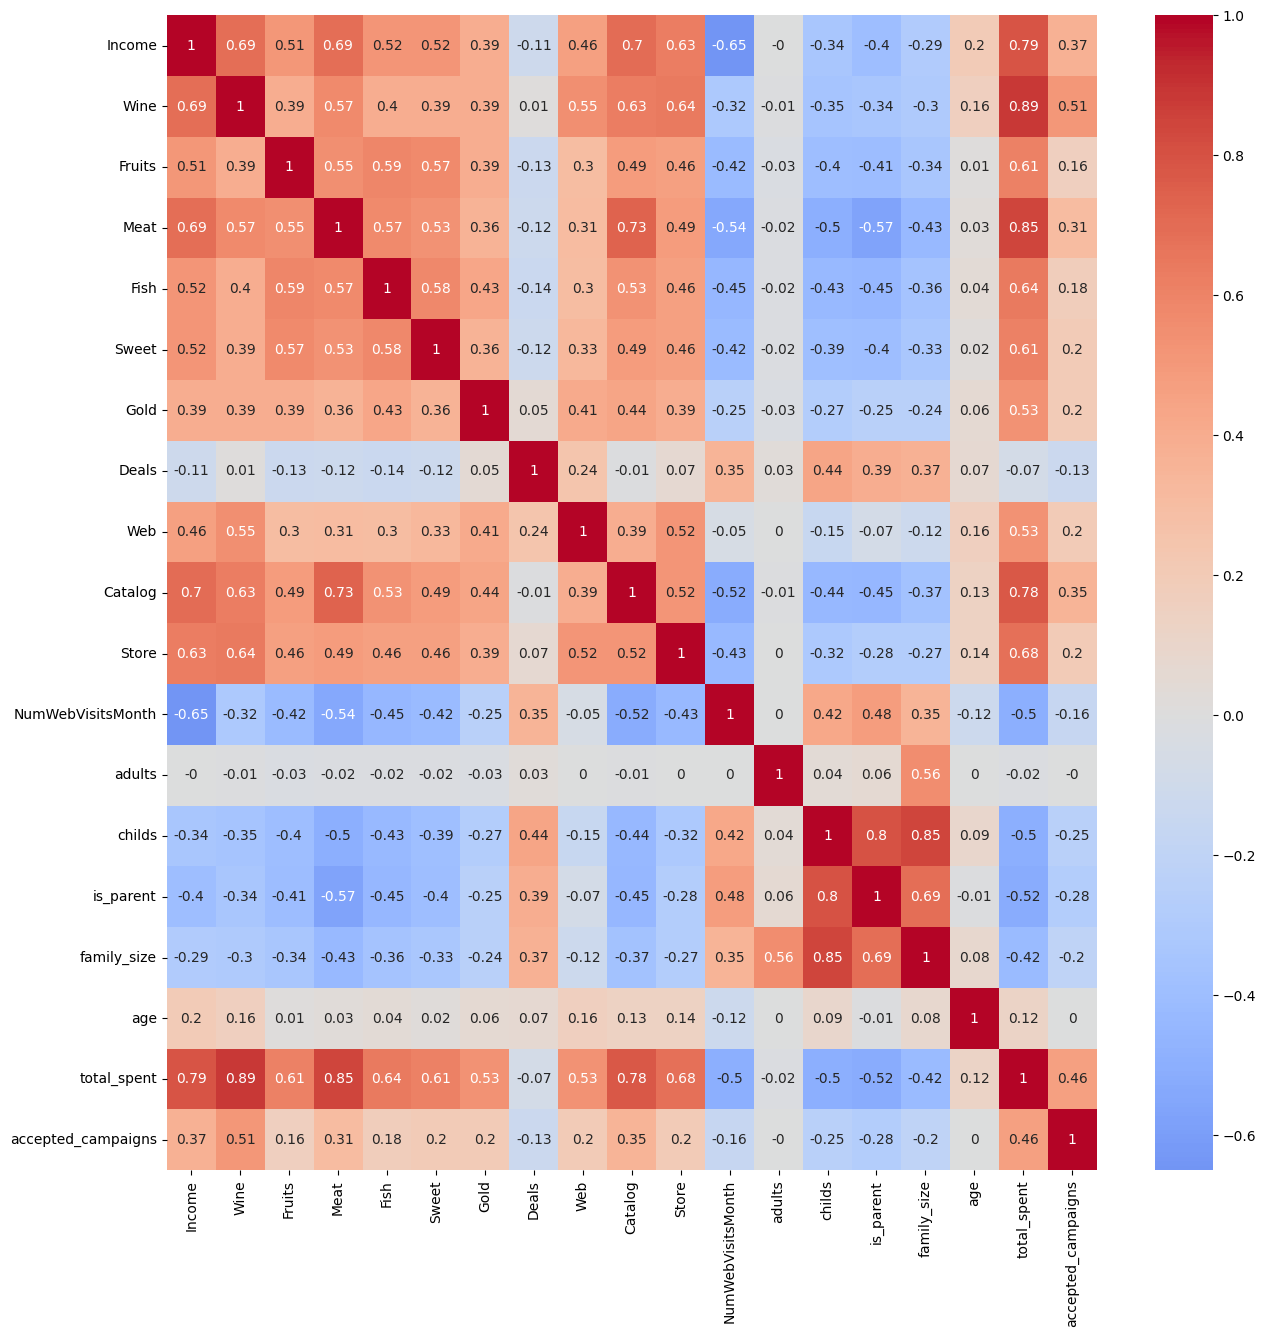

In [10]:
drop_useless = ['Complain', 'Recency', 'Response', 'Education', 'tenure']

plt.figure(figsize=(15,15))

df = df.drop(columns=drop_useless)

sns.heatmap(df.corr().round(2),
            cmap='coolwarm', annot=True, center=0)

# Кластеризация данных

### Подготовка данных к кластеризации: 
1. **Масштабирование данных:**  
   - Для нормализации числовых признаков используется `StandardScaler`.  
   - Это важно для алгоритмов кластеризации, которые чувствительны к масштабам данных, таких как `KMeans` и `AgglomerativeClustering`.  
   - Результат масштабирования — массив `scaled_df`.  

2. **Снижение размерности:**  
   - Для уменьшения количества признаков используется метод главных компонент (PCA).  
   - Выбрано три компоненты (`n_components=3`), которые объясняют наибольшую долю вариативности данных.  
   - Преобразованный датасет преобразуется в `DataFrame` с новыми колонками: `col1`, `col2`, `col3`.  
   - Снижение размерности упрощает визуализацию данных и может повысить эффективность кластеризации.  


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

pca = PCA(n_components=3)
scaled_df = pd.DataFrame(pca.fit_transform(scaled_df), columns=['col1', 'col2', 'col3'])

scaled_df

col1      col2      col3
0     4.655921 -0.411386  1.647562
1    -2.642059 -0.342722  0.223020
2     2.267460 -0.491485 -0.444415
3    -2.628528 -0.776539 -0.687345
4    -0.508856  0.932922 -0.435212
...        ...       ...       ...
2207  2.220800  2.096894  0.089416
2208 -2.016099  4.511421 -0.161713
2209  2.549510 -1.753383  1.678421
2210  1.428048  1.459340 -0.972263
2211 -2.505331  1.419564 -0.950852

[2212 rows x 3 columns]

### Определение оптимального числа кластеров

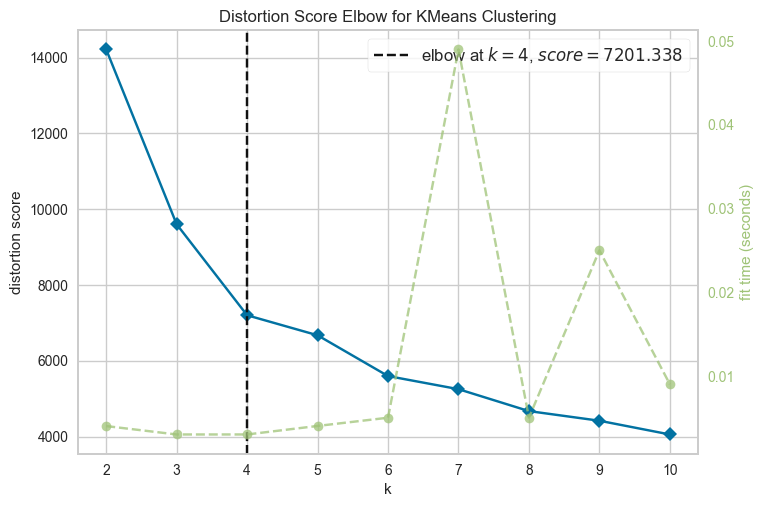

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
kev = KElbowVisualizer(KMeans(n_init='auto'), k=10)
kev.fit(scaled_df)
kev.show()

При применении `KElbowVisualizer` выяснили, что наилучшее значение для `k` — 4.
Это означает, что для данного датасета оптимально разделить его на 4 кластера.  

### Кластеризация с использованием AgglomerativeClustering

**Алгоритм:**  
Для выполнения кластеризации данных используем метод иерархической агломеративной кластеризации (`AgglomerativeClustering`).

**Шаги:**
1. **Параметры алгоритма:**  
   - Установим число кластеров `n_clusters=4`, так как по результатам метода локтя оптимальное число кластеров равно 4.
   
2. **Кластеризация:**  
   Применяем кластеризацию к данным и добавляем полученные метки кластеров в новый столбец `cluster` в датасет.

**Результат:**  
В датасете появляется новый столбец cluster, который указывает, к какому кластеру принадлежит каждый объект. 

In [14]:
clust = AgglomerativeClustering(n_clusters=4)
predict = clust.fit_predict(scaled_df)
scaled_df['cluster'] = predict
df['cluster'] = predict

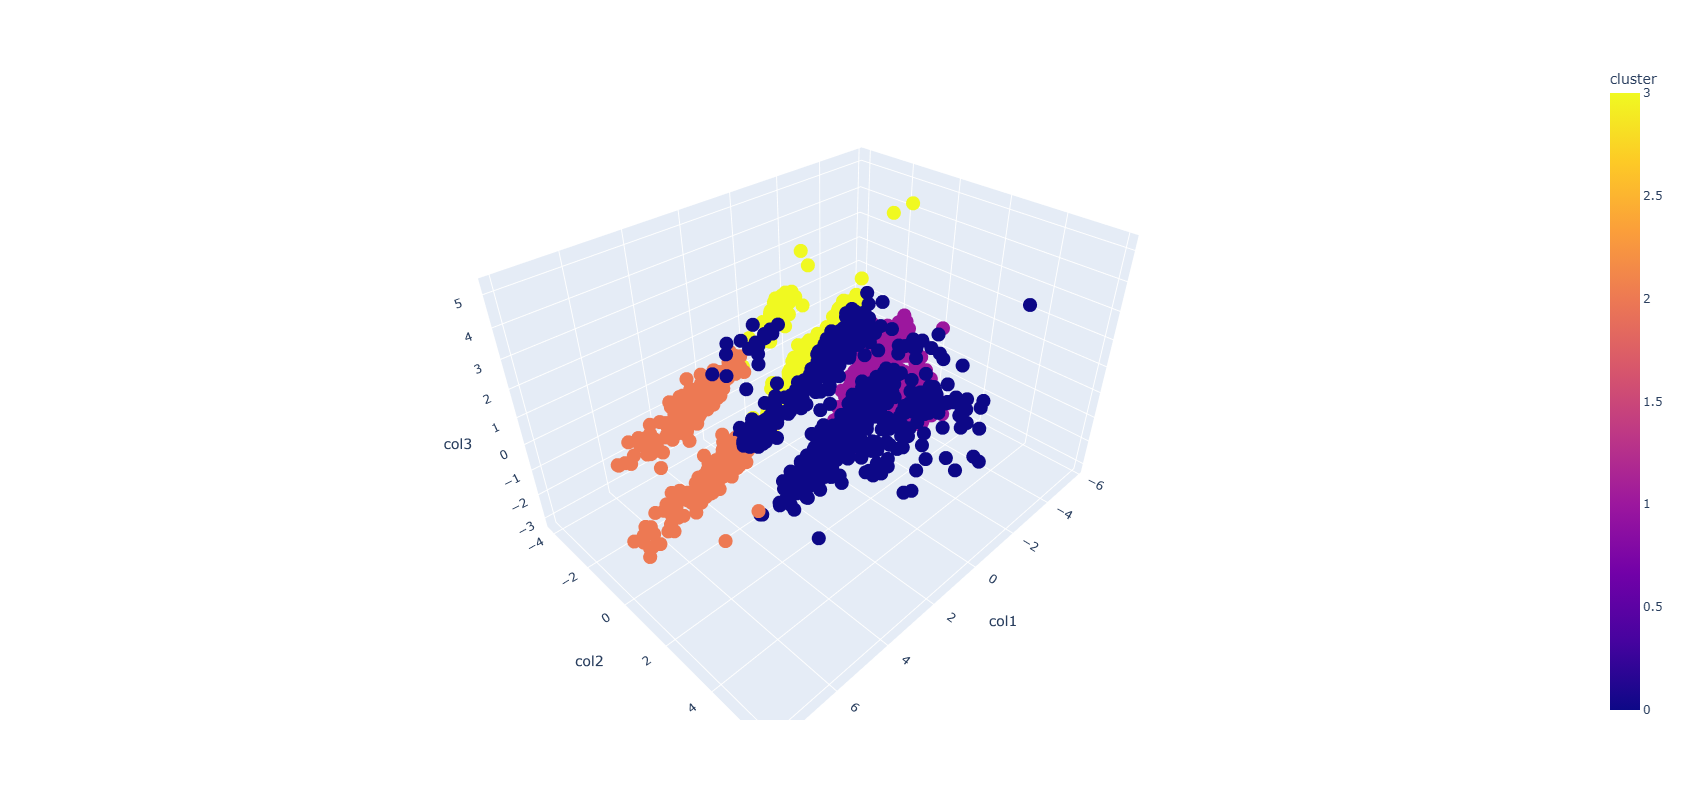

In [15]:
x = scaled_df['col1']
y = scaled_df['col2']
z = scaled_df['col3']

px.scatter_3d(scaled_df, x=x, y=y, z=z, color='cluster',
             width=800, height=800)

### Исследование особенностей кластеров

**План:**

1. **Описать каждый кластер**:  
   Для каждого кластера будет полезно исследовать средние значения признаков (например, возраст, доход, общие расходы), чтобы выявить характерные особенности клиентов, входящих в этот кластер.

2. **Выявить закономерности**:  
   Анализ различий между кластерами поможет понять, как сегменты пользователей различаются по ключевым меткам, таким как:
   - Поведение клиентов (например, покупательская активность),
   - Социально-демографические характеристики (например, возраст, статус семьи),
   - Взаимодействие с маркетинговыми акциями и предпочтения в покупках.

3. **Применить результаты для целевых стратегий**:  
   Полученные данные могут быть использованы для разработки таргетированных маркетинговых стратегий.

Этап также включает в себя визуализацию кластеров, чтобы показать их различия и взаимосвязи.  


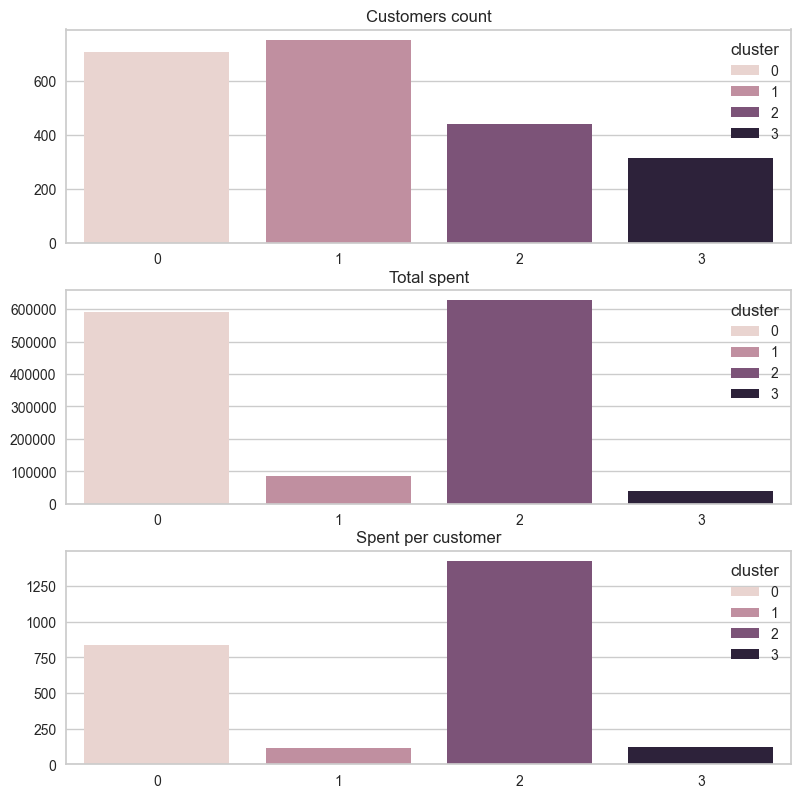

In [28]:
g = df.groupby('cluster', as_index=False).agg({"total_spent": "sum",
                                               "Fish": "count"
                                             }) \
                                        .rename({"Fish": "customers_count"}, axis=1)

g['spent_per_customer'] = g.total_spent / g.customers_count

fig, axes = plt.subplots(3, 1, figsize=(8, 8))

fig.tight_layout()

for idx, i in enumerate(['customers_count', 'total_spent', 'spent_per_customer']):
    sns.barplot(g, x='cluster', y=i,
                hue='cluster',
                ax=axes[idx])
    axes[idx].set_title(i.replace('_', ' ').capitalize())
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

<Axes: xlabel='cluster', ylabel='total_spent'>

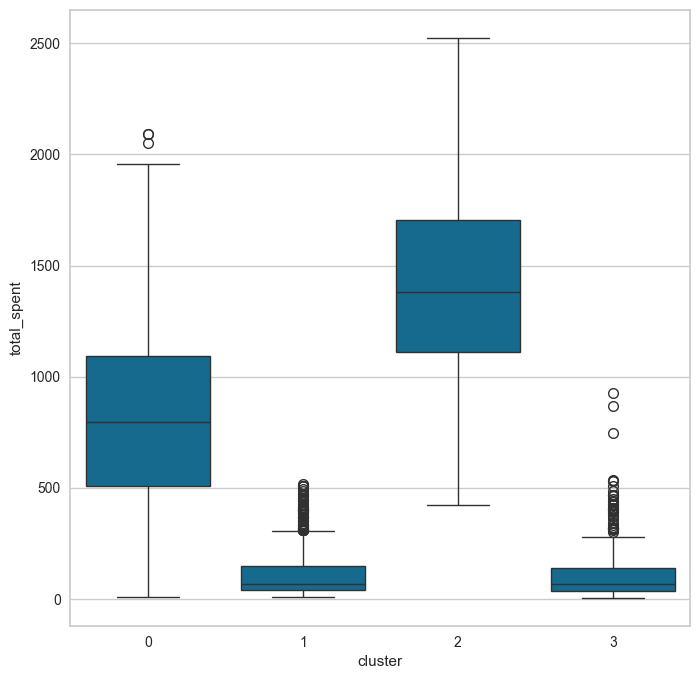

In [88]:
plt.figure(figsize=(8,8))

sns.boxplot(df, x='cluster', y='total_spent')

### Анализ кластеров

После выполнения кластеризации, мы получили следующие характеристики для каждого кластера:

1. **Размер кластера (`customers_count`)**:  
   Кластер 1 содержит наибольшее количество клиентов, в то время как кластер 3 — наименьшее.

2. **Общие расходы по каждому кластеру (`total_spent`)**:  
   Кластер 2 имеет наибольшие общие расходы, что может свидетельствовать о высоком уровне потребления в этой группе.

3. **Средние расходы на одного клиента (`spent_per_customer`)**:  
   Кластер 2 отличается высокими расходами на клиента по сравнению с остальными кластерами, что указывает высокую покупательскую способность.

**Выводы:**  
- Кластер 2 явно выделяется по уровню потребительских расходов, и это может быть сегментом с наиболее прибыльными клиентами.
- Кластер 1, хотя и имеет большое количество клиентов, имеет гораздо более низкие средние расходы на одного клиента.
- Кластеры 0 и 3 имеют средние расходы.


Text(0.5, 1.0, 'Количество участий в акциях')

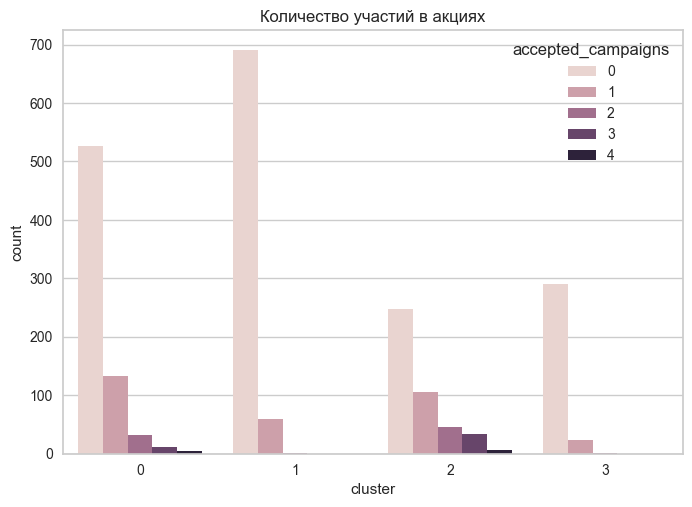

In [31]:
plt.tight_layout()
sns.countplot(df, x='cluster', hue='accepted_campaigns')
plt.title('Количество участий в акциях')

<Figure size 800x550 with 0 Axes>

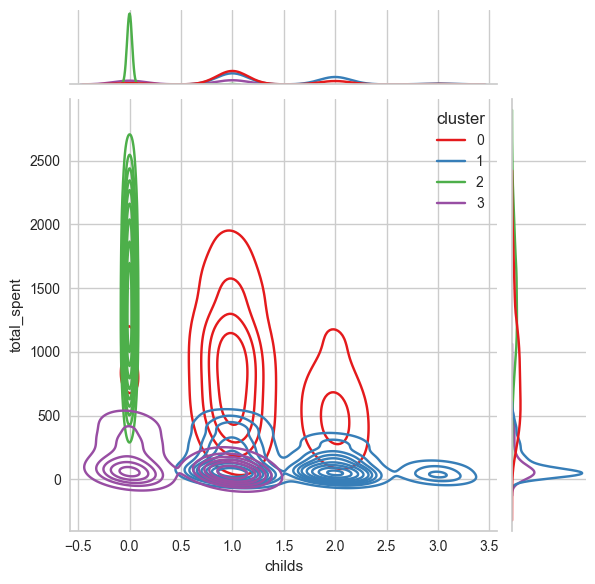

<Figure size 800x550 with 0 Axes>

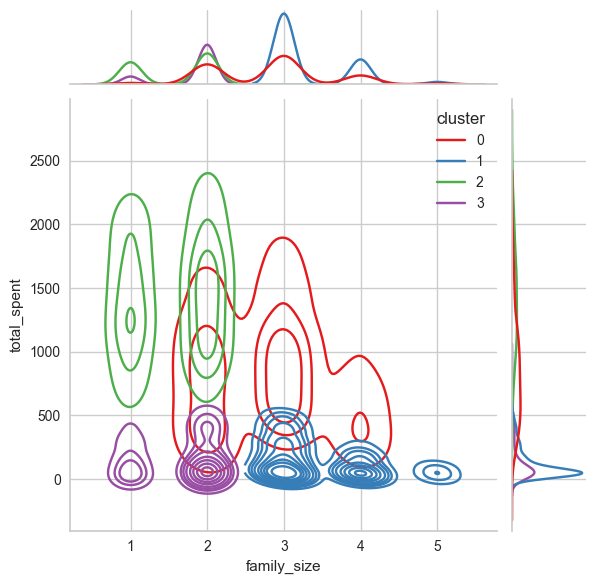

<Figure size 800x550 with 0 Axes>

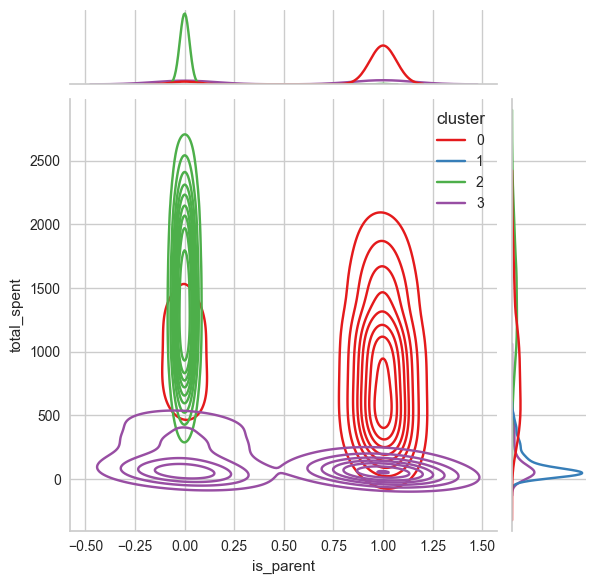

<Figure size 800x550 with 0 Axes>

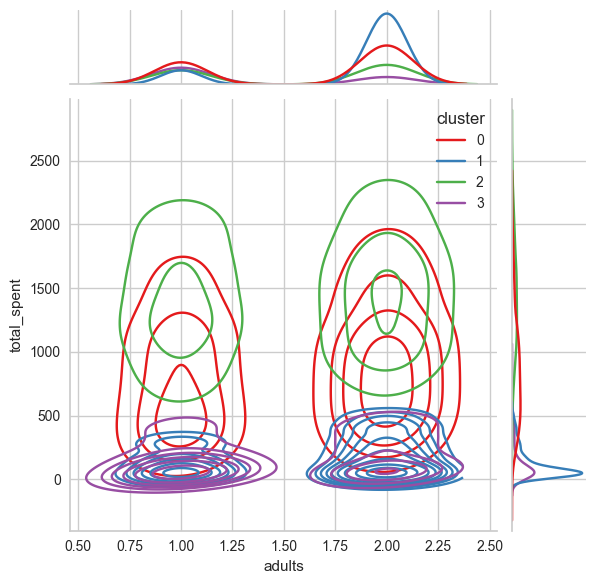

<Figure size 800x550 with 0 Axes>

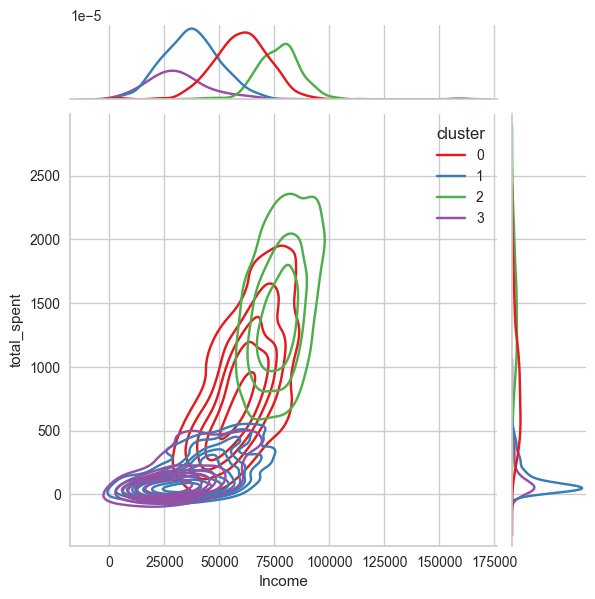

In [18]:
Personal = ["childs", "family_size", "is_parent", "adults", "Income"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["total_spent"], hue=df["cluster"], kind="kde", palette='Set1')
    plt.show()

### Демографические характеристики кластеров

1. **Количество детей**:
   - **Кластер 0**: 1-3 ребёнка.
   - **Кластер 1**: Равномерное распределение 1-2 детей.
   - **Кластер 2**: Без детей.
   - **Кластер 3**: В большинстве случаев 1 ребёнок, реже 0.

2. **Размер семьи**:
   - **Кластер 0**: 3-5 человек.
   - **Кластер 1**: 2-4 человека.
   - **Кластер 2**: 1-2 человека.
   - **Кластер 3**: 1-2 человека.

4. **Являются ли родителями**:
   - **Кластер 0**: 50% — родители.
   - **Кластер 1**: 80% — родители.
   - **Кластер 2**: Нет.
   - **Кластер 3**: 50% — родители.

6. **Доход**:
   - **Кластер 0**: Средний доход.
   - **Кластер 1**: Низкий доход.
   - **Кластер 2**: Наибольший доход.
   - **Кластер 3**: Низкий доход.

**Выводы**:
- **Кластер 0** — семьи с детьми среднего дохода.  
- **Кластер 1** и **кластер 3** — семьи с детьми, но с низким доходом.
- **Кластер 2** — семьи без детей с высоким доходом.


## Построение матрицы корреляций для переменных, связанных с расходами и покупательской активностью

**Цель:**  
Построить матрицу корреляций для переменных, которые отражают расходы и активность клиентов, чтобы:  
- Оценить взаимосвязь между различными аспектами покупок (например, расходы на разные категории товаров, покупки через различные каналы).
- Выявить возможные зависимости между признаками, что поможет более глубоко понять особенности кластеров и поведение пользователей в каждом из них.

**Переменные для анализа:**  
- **Общие расходы (`total_spent`)**: Сумма расходов по всем категориям товаров.
- **Активность по различным каналам продаж**:  
  - **`Deals`**: Количество покупок по акции.
  - **`Web`**: Количество покупок через интернет.
  - **`Catalog`**: Количество покупок по каталогу.
  - **`Store`**: Количество покупок в магазине.
  - **`NumWebVisitsMonth`**: Количество посещений веб-сайта за месяц
- **Расходы по категориям товаров**:  
  - **`Wine`**: Расходы на вино.
  - **`Fruits`**: Расходы на фрукты.
  - **`Meat`**: Расходы на мясные продукты.
  - **`Fish`**: Расходы на рыбу.
  - **`Sweet`**: Расходы на сладости.
  - **`Gold`**: Расходы на ювелирные изделия.

**Действия:**  
1. Построим матрицу корреляций для этих переменных, чтобы увидеть, как они взаимосвязаны.  
2. Используем тепловую карту (`heatmap`), чтобы визуализировать корреляции между переменными.


<Axes: >

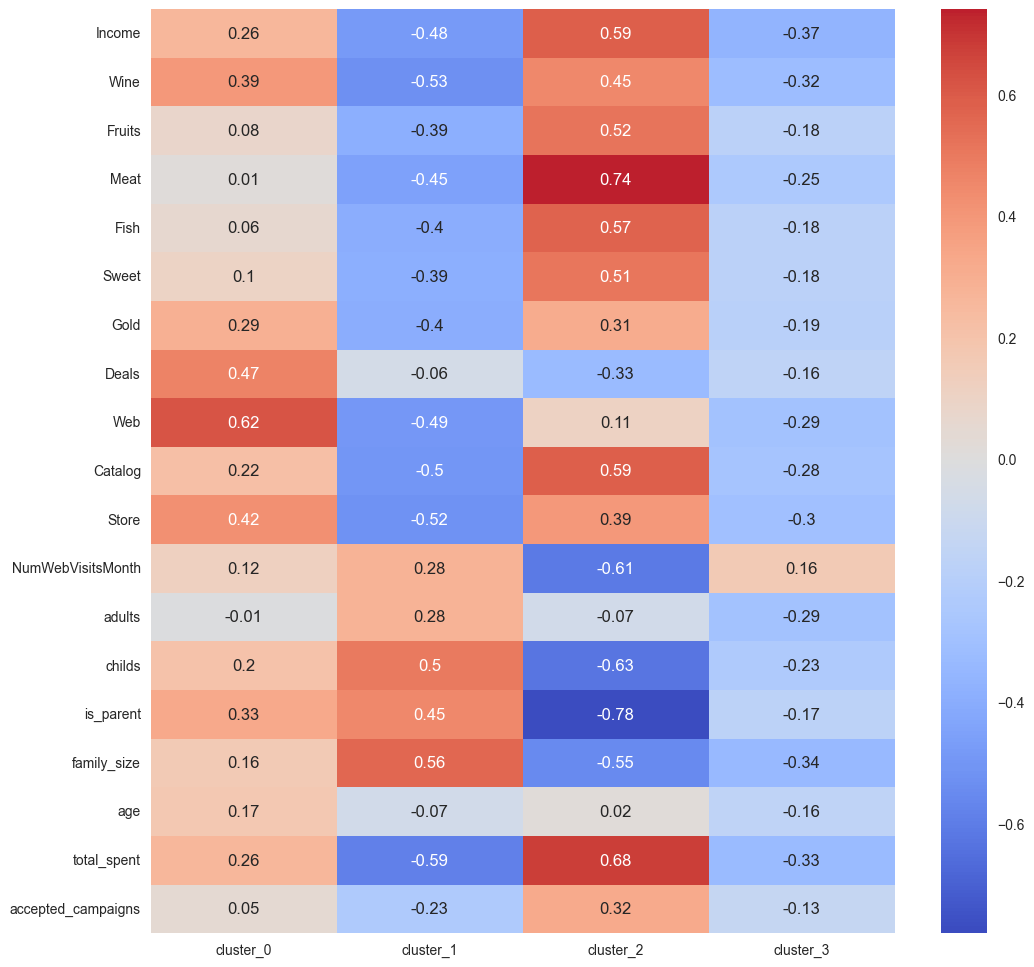

In [33]:
cluster_dummy = pd.get_dummies(df, columns=['cluster'])

plt.figure(figsize=(12,12))

sns.heatmap(cluster_dummy.corr().round(2)[['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']].drop(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']),
            annot=True, center=0, cmap='coolwarm')

### Корреляция кластеров

1. **Кластер 0**:
   - **Положительная корреляция** (0.49) с количеством покупок по акции и с количеством покупок через интернет (0.6), что свидетельствует о высоком уровне вовлеченности в акционные предложения и онлайн-покупки.
   - **Положительная корреляция** только с категориями товаров "gold" и "wine", что указывает на специализацию клиентов этого кластера на определенные товары.

2. **Кластер 1**:
   - **Сильная отрицательная корреляция** с доходом и общими расходами (`total_spent`), что указывает на более низкую покупательскую активность в этих категориях.
   - **Положительная корреляция** с числом посещений веб-сайта в месяц (0.28), что может свидетельствовать о высоком уровне онлайн-активности.
   - **Отрицательная корреляция** с количеством кампаний, в которых клиент участвовал (-0.3), и с общими расходами (-0.6), что указывает на более низкую вовлеченность в маркетинговые акции.

3. **Кластер 2**:
   - **Сильная положительная корреляция** с доходом и общими расходами (0.7), что подтверждает высокую покупательскую способность этой группы.
   - **Отрицательная корреляция** с количеством покупок по акции (-0.34) и с числом посещений веб-сайта (-0.6).
   - **Положительная корреляция** с количеством покупок по каталогу (0.6) и с количеством кампаний, в которых клиент участвовал (0.3), что может указывать на активных участников маркетинговых акций и покупки через каталог.

4. **Кластер 3**:
   - **Отрицательная корреляция** (-0.18 до -0.37) со всеми категориями продуктов и каналами продаж, что свидетельствует о более низкой активности и меньших расходах на продукты и каналы, такие как интернет и магазины.
   - **Слабая отрицательная корреляция** с доходом и общими расходами, что может означать более низкий уровень покупательской активности и дохода.

**Выводы**:
- **Кластер 0** характеризуется высокой активностью в акциях и покупках через интернет, но с акцентом на определенные товарные категории (gold и wine).
- **Кластер 1** отличается низкой покупательской активностью и высоким уровнем онлайн-активности, но меньшей вовлеченностью в маркетинговые акции.
- **Кластер 2** имеет высокие доходы и расходы, активно участвует в акциях и покупает через каталог.
- **Кластер 3** имеет низкие показатели покупок, вовлеченности и дохода, что указывает на низкую активность в этом сегменте.



# Выводы

### Кластер 0
**Общее описание:**  
Клиенты этого кластера активно участвуют в акциях и делают покупки через интернет. Они демонстрируют средний уровень дохода и могут быть ориентированы на выгодные предложения.

**Покупательское поведение:**
- **Высокая активность в покупках по акции и через интернет**.
- **Средние расходы** по большинству категорий товаров, но с явным предпочтением к акциям.
- **Посещения сайта с регулярностью**, что подтверждает их интерес к предложениям.

**Рекомендации:**
- Разработать и продвигать акционные предложения, так как эти клиенты ценят скидки и выгодные условия.
- Увеличить количество онлайн-акций и предложений, чтобы усилить интернет-покупки.
- Рассмотреть программу лояльности, которая поощряет частоту покупок и регулярность посещений сайта.

### Кластер 1
**Общее описание:**  
Клиенты этого кластера имеют наименьший доход и расходы. 
Они характеризуются низким уровнем активности, с минимальным вовлечением в маркетинговые кампании.

**Покупательское поведение:**
- **Низкие расходы на все товары** (в том числе на товары по акции и в интернете).
- **Малая активность** в покупках по акциям и через интернет.
- **Активные посетители сайта**, но не склонны совершать покупки.
- **Низкая вовлеченность в кампании**, что свидетельствует о слабой привязанности к бренду и продуктам.

**Рекомендации:**
- Необходимо предложить более привлекательные акции или скидки, чтобы стимулировать покупки.
- Важно увеличить вовлеченность через персонализированные предложения, которые могут подтолкнуть их к активным покупкам.
- Программы лояльности и дополнительные бонусы могут помочь повысить приверженность бренду.

### Кластер 2
**Общее описание:**  
Этот кластер включает клиентов с высоким доходом, которые тратят значительные суммы на покупки. Эти клиенты предпочитают делать покупки без акций и склонны использовать другие каналы, такие как каталог, чтобы совершать покупки.

**Покупательское поведение:**
- **Высокие расходы** на различные категории товаров, включая продукты премиум-класса (например, вино и мясо).
- **Низкая активность в покупках по акциям**.
- **Положительная корреляция с покупками по каталогу** и меньшая активность в интернете.
- **Хорошая вовлеченность в маркетинговые кампании**.

**Рекомендации:**
- Предложить более эксклюзивные и премиум-продукты, которые соответствуют их высоким доходам и покупательским предпочтениям.
- Разработать персонализированные предложения по каталогам, так как этот канал для них важен.
- Для повышения лояльности стоит рассмотреть создание программ, ориентированных на премиум-сегмент, с преимуществами и привилегиями.

### Кластер 3
**Общее описание:**  
Этот кластер включает клиентов с низким доходом и ограниченной покупательской активностью. Они в основном совершают покупки в определенных категориях товаров, преимущественно через интернет.

**Покупательское поведение:**
- **Низкие расходы** на все категории товаров, включая товары премиум-класса.
- **Активность в покупках через интернет**, но ограниченная активность в других каналах (например, магазин или каталог).
- **Низкая вовлеченность в маркетинговые акции** и участие в кампаниях.

**Рекомендации:**
- Фокусироваться на улучшении онлайн-опыта и увеличении доступности товаров через интернет-канал.
- Разработать специальные акции с акцентом на низкую цену и доступность, чтобы привлечь клиентов с ограниченным бюджетом.
- Внедрить targeted marketing стратегии, направленные на повышение вовлеченности в акции и увеличение покупок в других каналах.